In [ ]:
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

from graphvelo.plot import gene_score_histogram # , plot_velocity_phase

import project

FIG_DIR = "temp"

In [2]:
scv.settings.figdir = str(FIG_DIR)
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

In [3]:
save_figure = True

In [4]:
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Velocity estimation using scvelo

In [5]:
project.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

project.pp.pca(adata)
project.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
project.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
project.tl.recover_dynamics(adata, n_jobs=-1)
project.tl.velocity(adata, mode="dynamical")
project.tl.latent_time(adata)

recovering dynamics (using 22/22 cores)


  0%|          | 0/588 [00:00<?, ?gene/s]

    finished (0:01:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/22 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


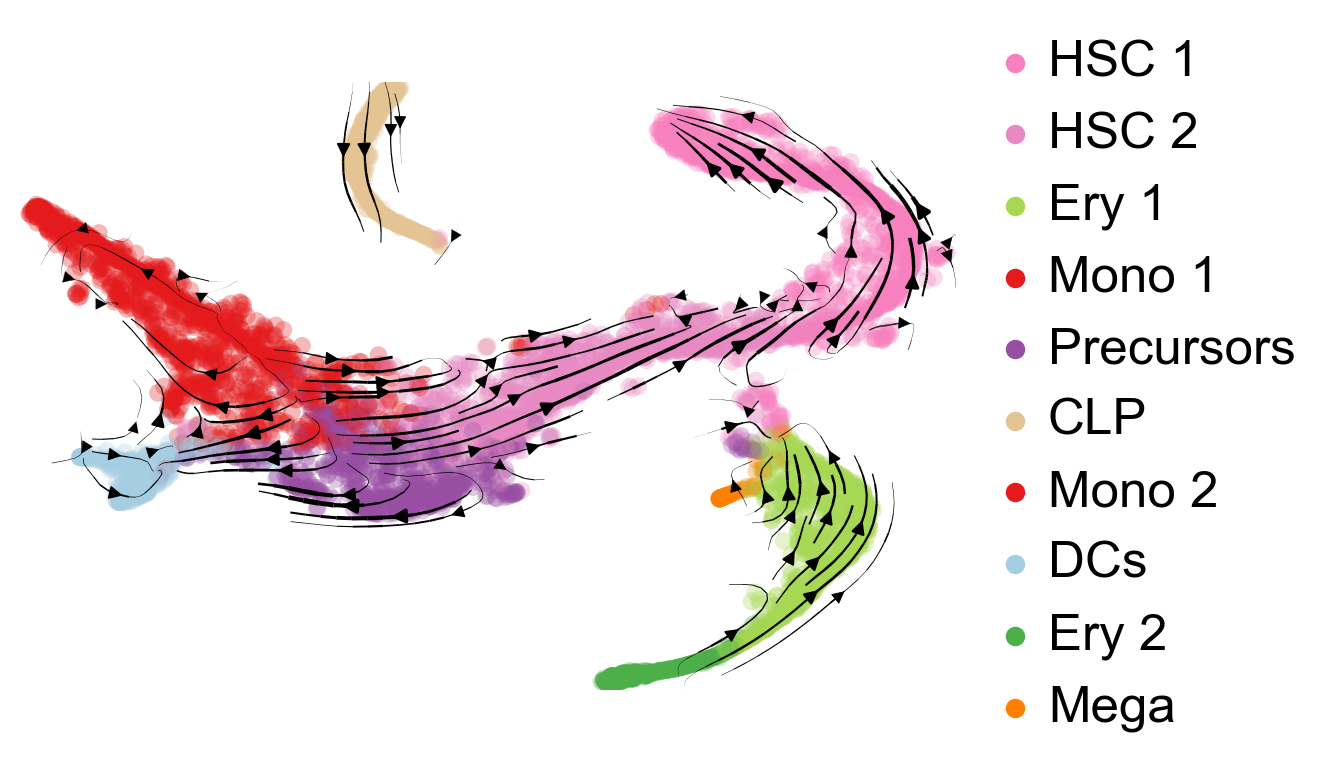

In [8]:
fig_kwargs = {'color': ['clusters'],
                 'legend_loc': 'right', 'dpi': 100, 'title': ''}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [9]:
genes = ['ANGPT1', 'RBPMS']

e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


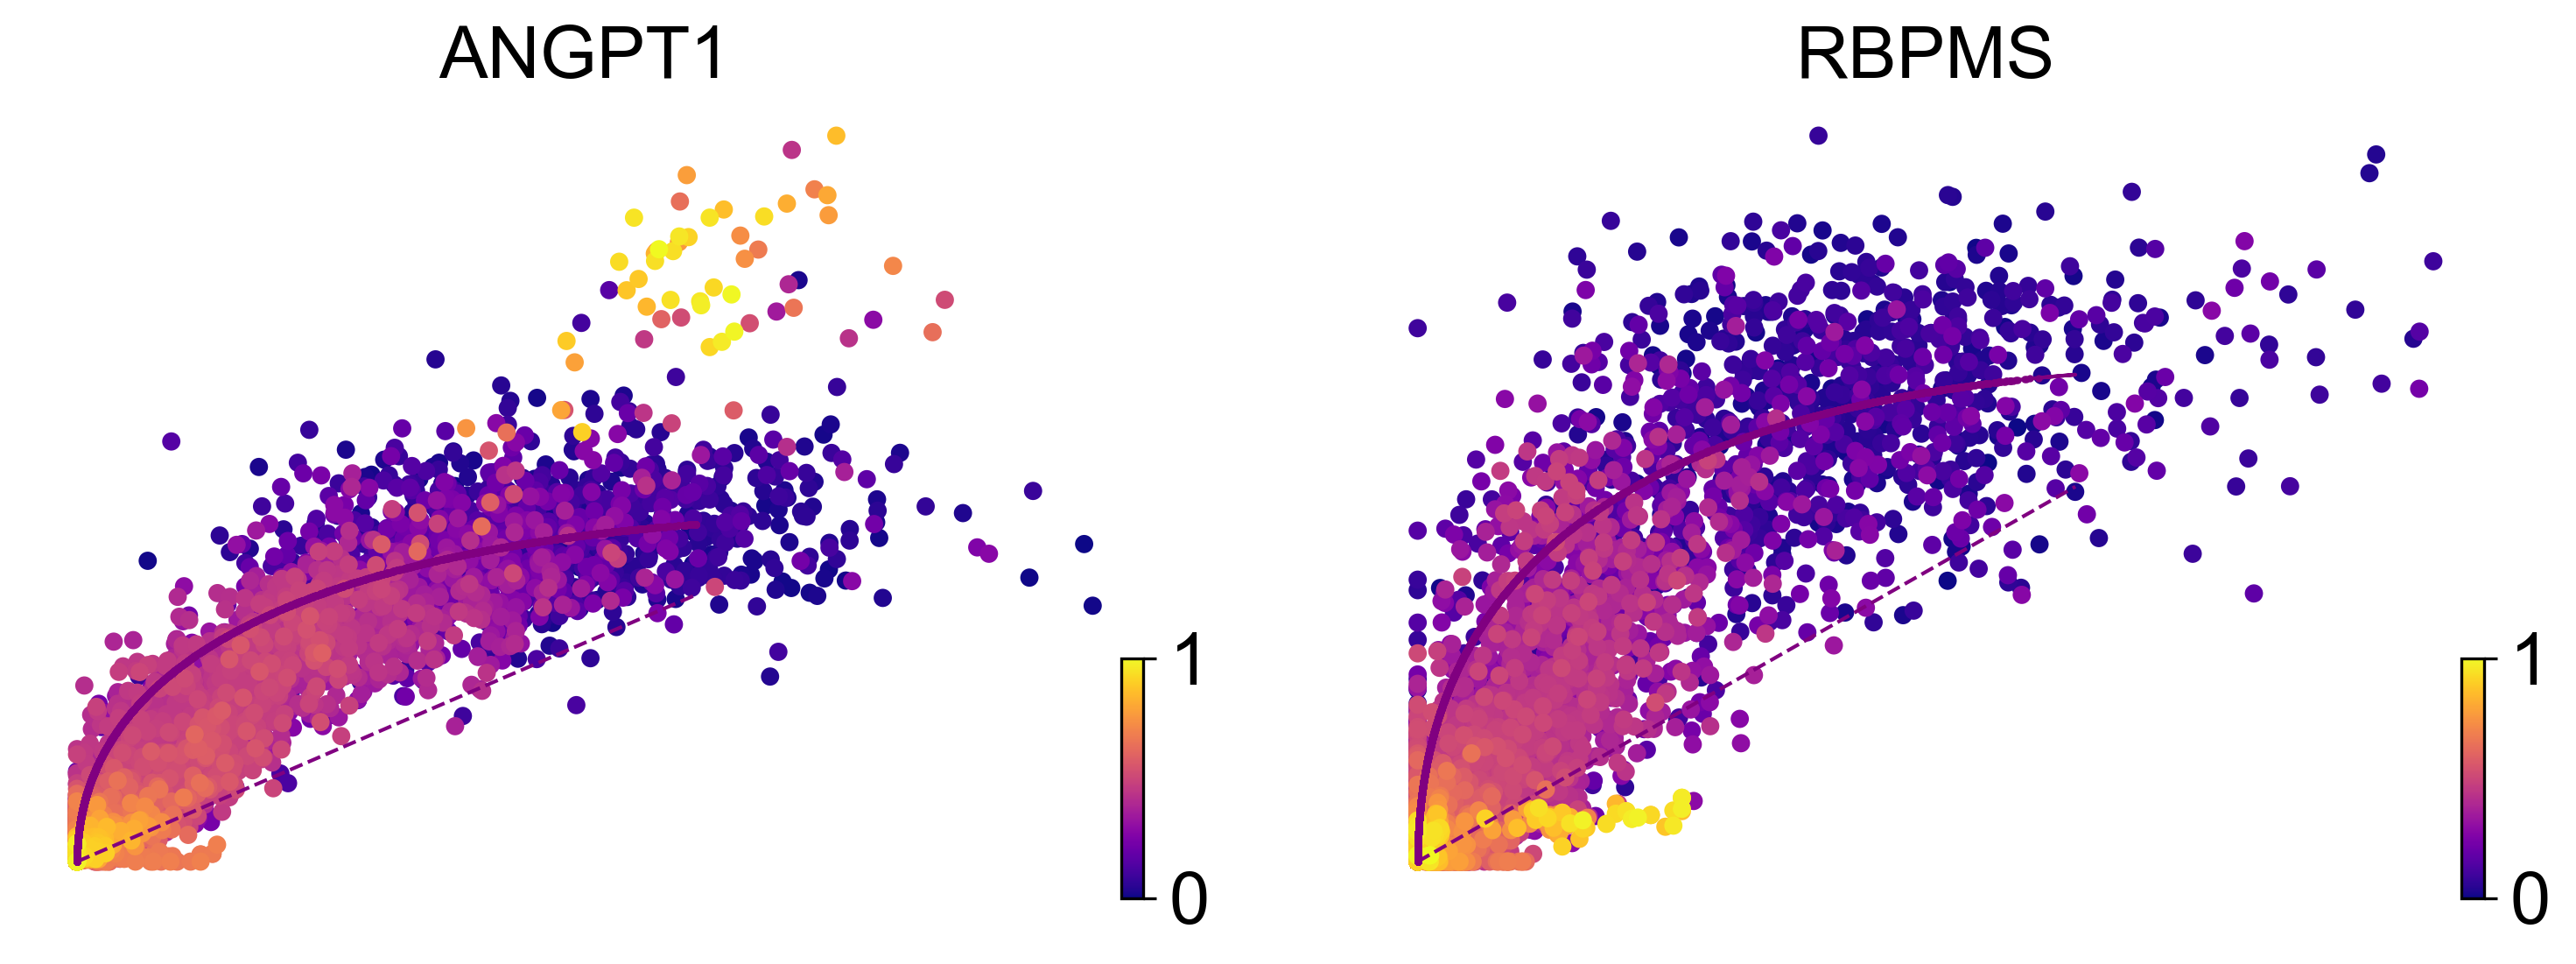

In [10]:
fig_kwargs = {'basis': genes, 'color': 'palantir_pseudotime', 'color_map': 'plasma', 'frameon': False, 's': 100, 'dpi': 150}
scv.pl.scatter(adata, **fig_kwargs)

high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [11]:
indices, _ = project.gv.adj_to_knn(adata.obsp['connectivities'])
adata.uns['neighbors']['indices'] = indices

In [12]:
project.gv.mack_score(adata, ekey='Ms', vkey='velocity', tkey='palantir_pseudotime')

calculating manifold-consistent scores in 22 cpu(s): 100%|██████████| 588/588 [00:45<00:00, 12.89it/s]


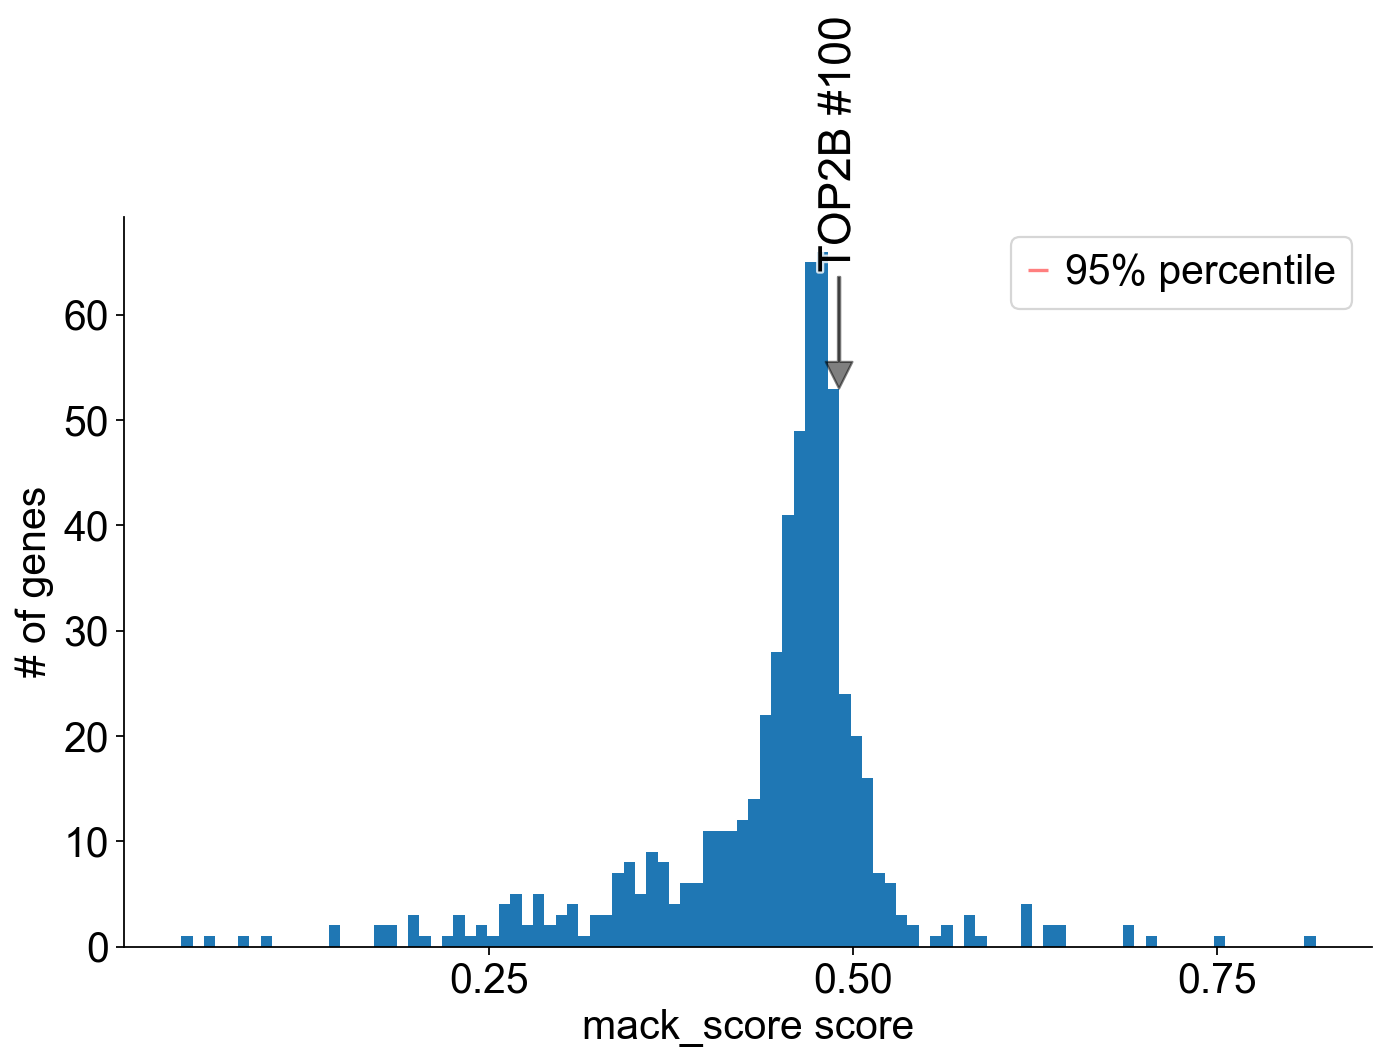

In [13]:
macKG = adata.var['mack_score'].sort_values(ascending=False)[:100].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key='mack_score')
plt.show()

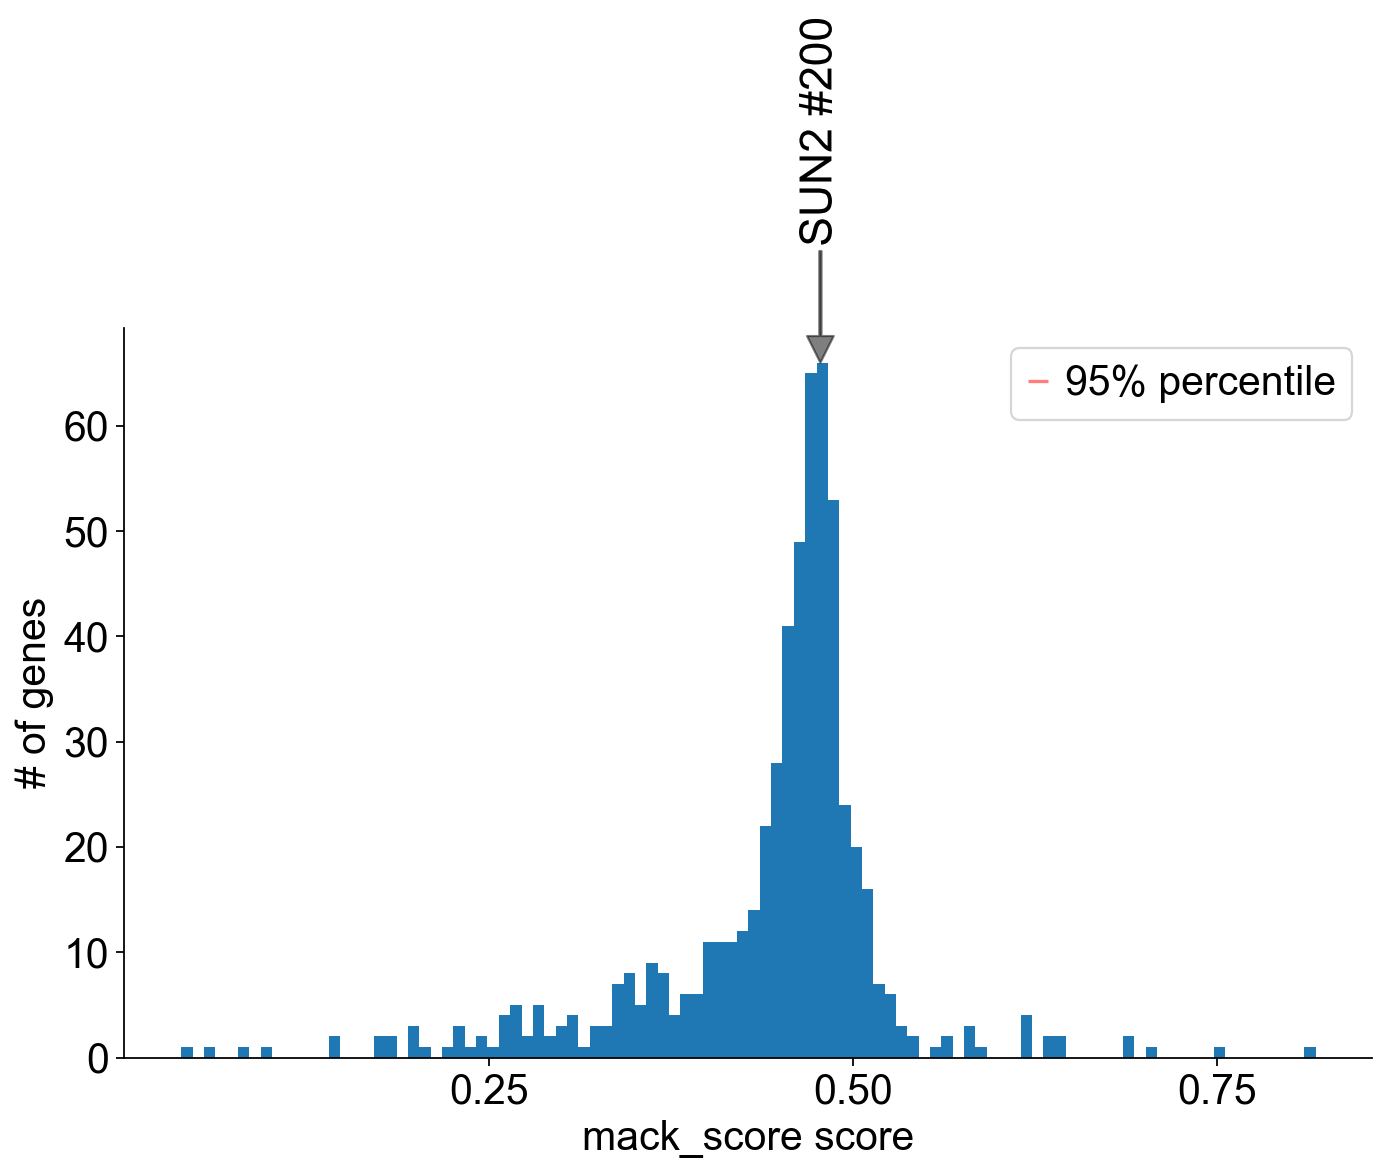

In [14]:
macKG_200 = adata.var['mack_score'].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG_200[-1]], score_key='mack_score')
plt.show()

Learning Phi in tangent space projection.: 100%|██████████| 5780/5780 [00:09<00:00, 624.71it/s]
e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


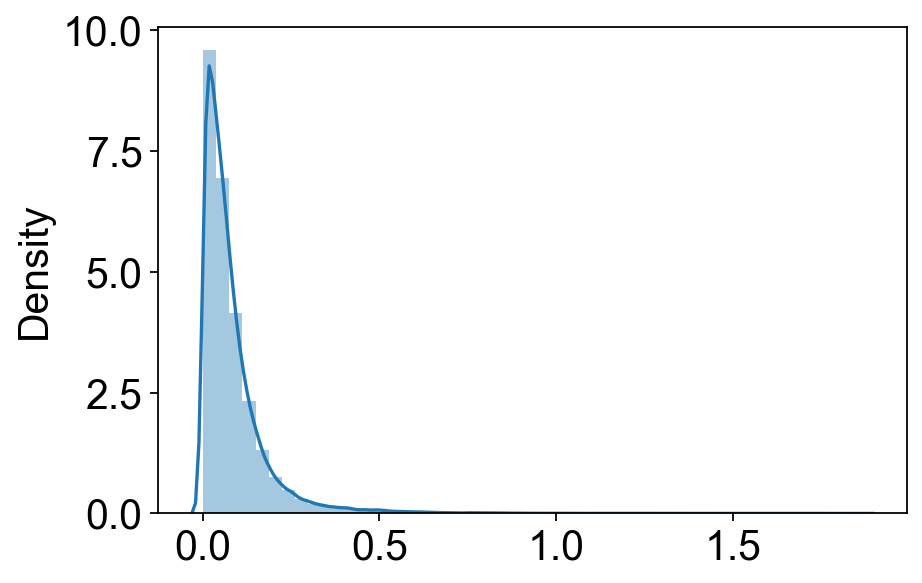

In [15]:
gv = project.gv.GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [16]:
adata.layers['velocity_gvs'] = gv.project_velocity(adata.layers['Ms'])
adata.layers['velocity_gvu'] = gv.project_velocity(adata.layers['Mu'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_tsne'] = gv.project_velocity(adata.obsm['X_tsne'])

projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:04<00:00, 1209.44it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:04<00:00, 1266.02it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 7857.01it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 7710.73it/s]


e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


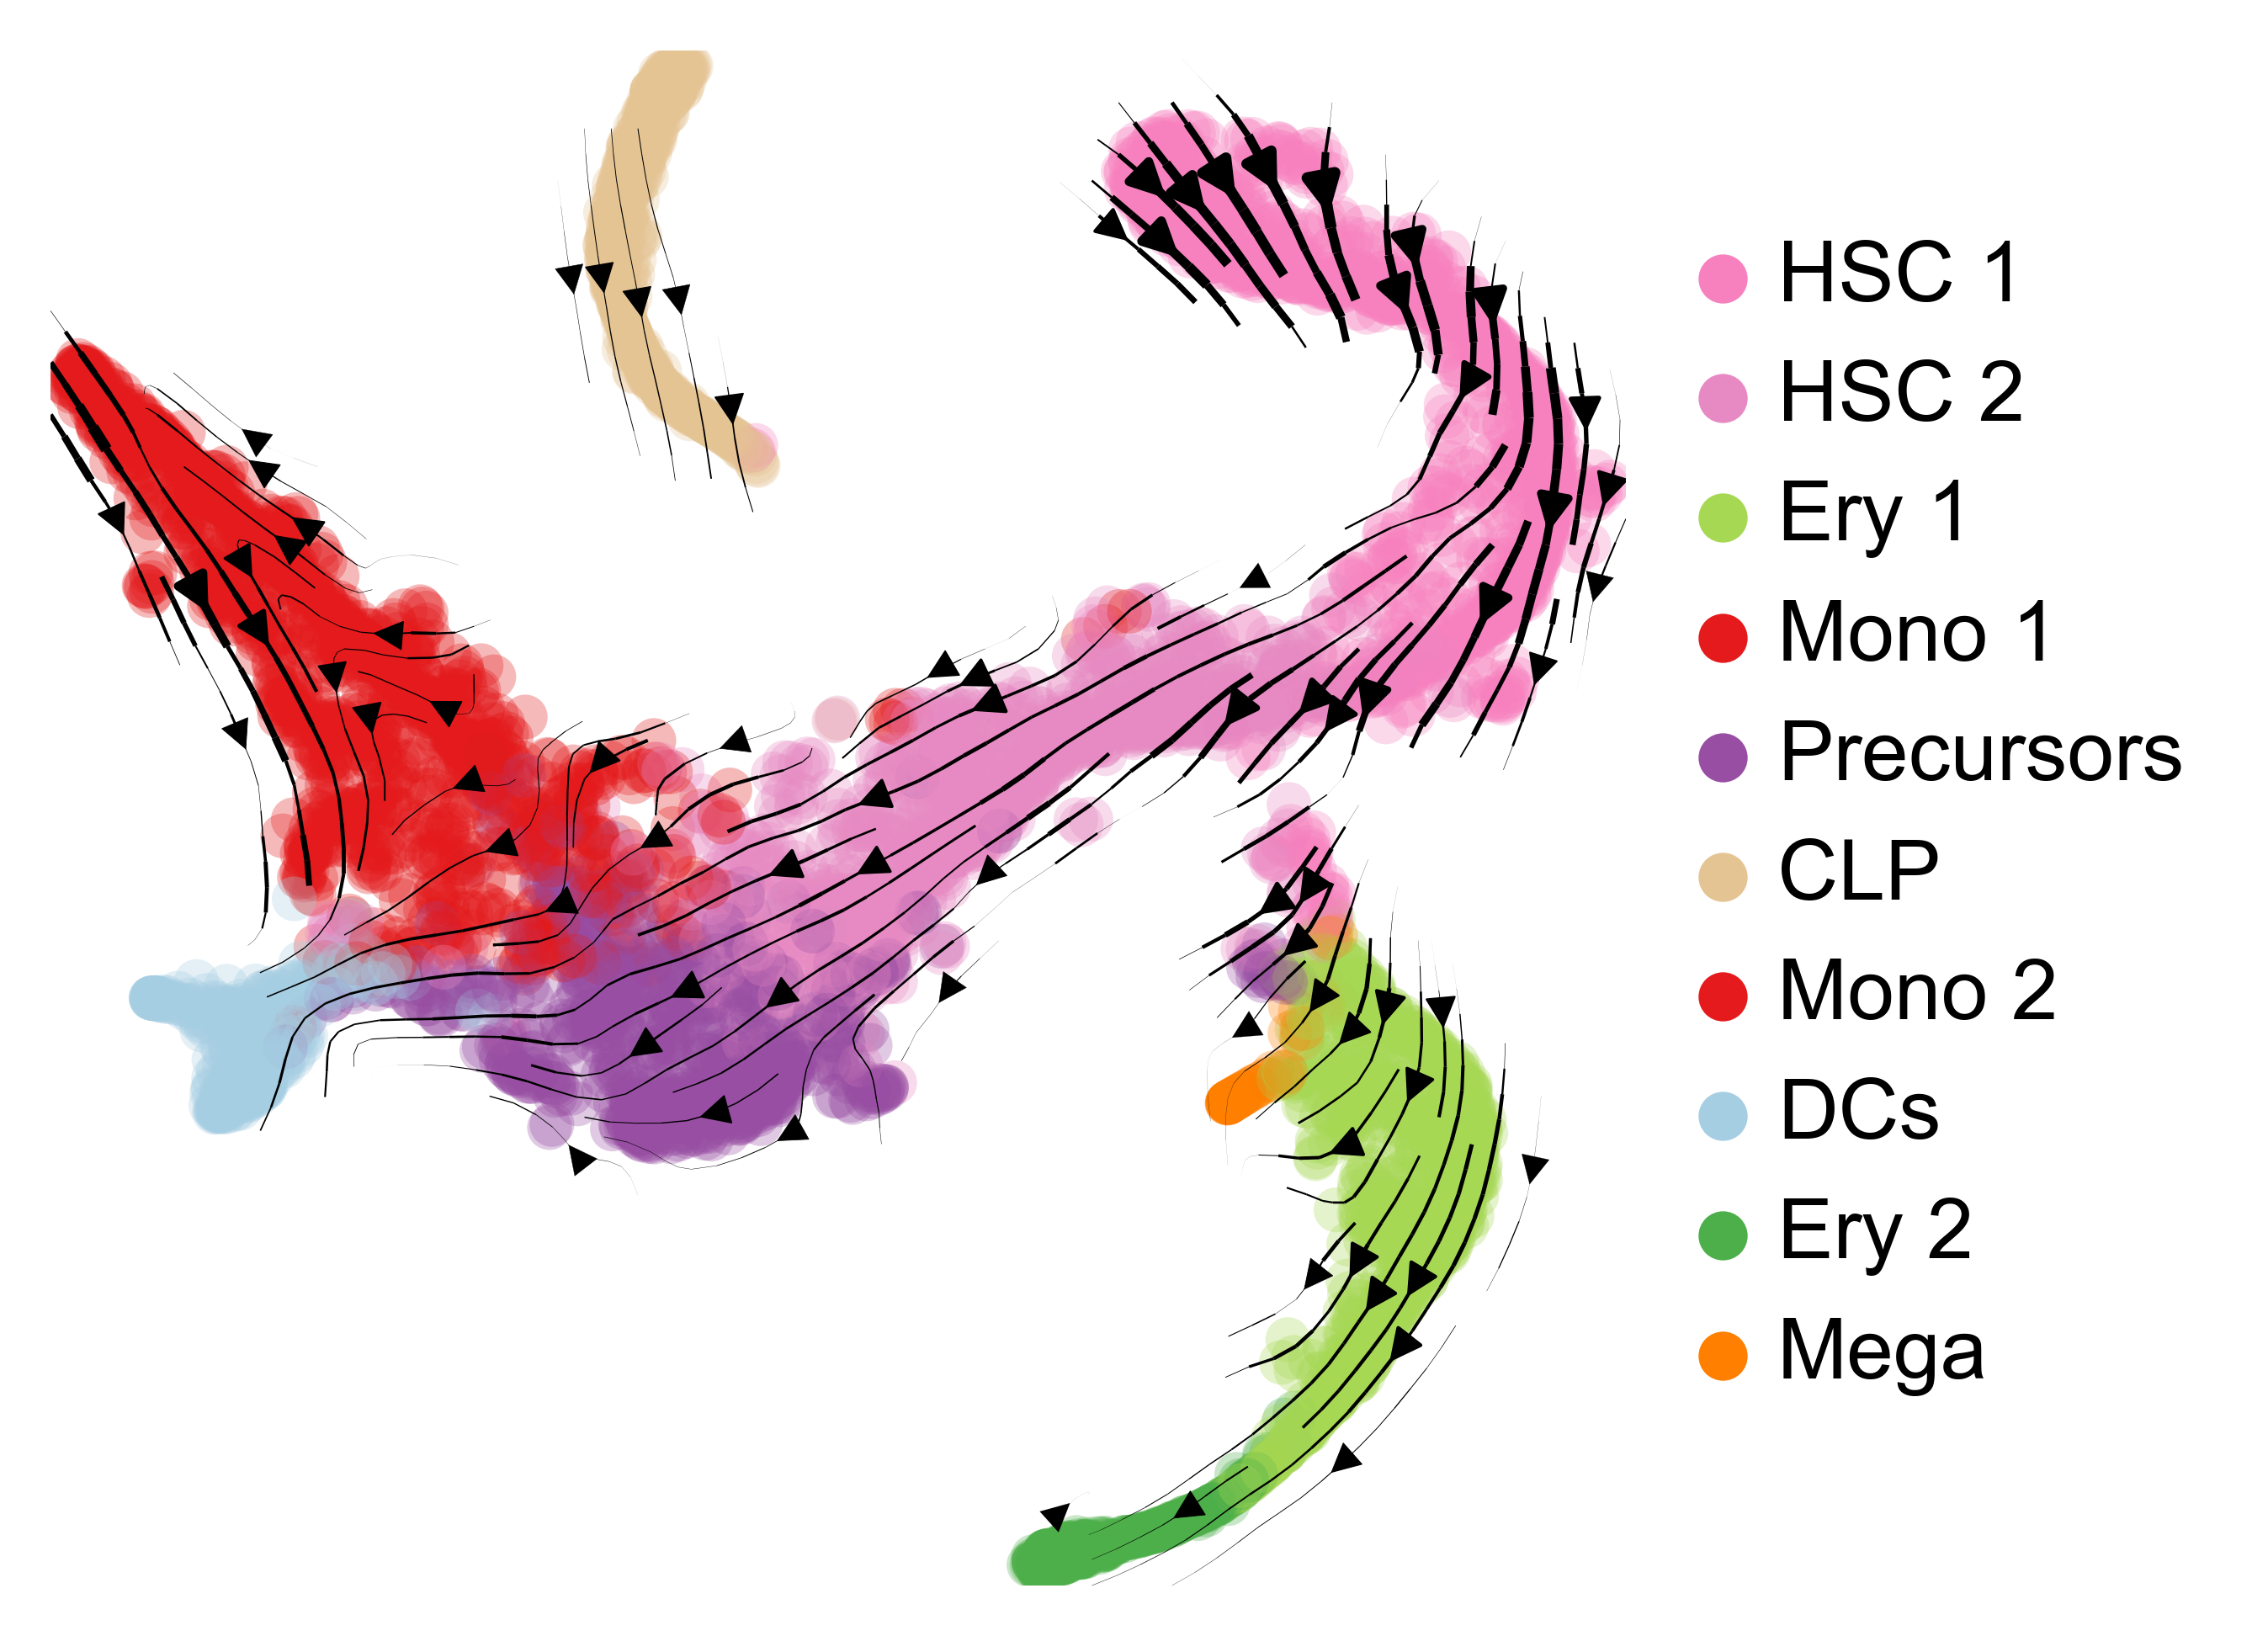

In [17]:
fig_kwargs = {'color': ['clusters'], 'X': adata.obsm['X_tsne'], 'V': adata.obsm['gv_tsne'],
                 'legend_loc': 'right', 'dpi': 300, 'title': '', 'legend_fontsize': 12, 'figsize': (4,4)}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)